# Model fitting for MetMCC-SCAN
## Yanrong (Jerry) Ji

## TODO:
- build a pipeline for preprocessing
>- further group some levels and compare
>- missing val: imputation/leave as it is
>- more feature engineering?
- bayesian optimization (done)
- merge SEER data
- bagged XGBoost

## Major issues:
- Categorical + Numeric
- Missing values
- Imbalance

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost
# !pip install scikit-optimize
# !pip install imblearn

In [1]:
# general modules
import os
from copy import deepcopy
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import accuracy_score,confusion_matrix, auc, roc_auc_score
from sklearn.metrics import roc_curve, f1_score, average_precision_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, make_scorer
from sklearn.impute import KNNImputer

# xgboost,lightgbm,catboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Bayesian optimization
from skopt import BayesSearchCV
from skopt import callbacks
from skopt.space import Real, Integer

# Class imbalance
from imblearn.over_sampling import SMOTENC
from imblearn.ensemble import BalancedRandomForestClassifier

# set seaborn style
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)
sns.set(font_scale=1.5)

In [2]:
BASE_DIR = os.path.dirname(os.path.realpath('model_fitting')) + '/'

In [3]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_augmented_clean.pkl')

In [5]:
mcc_ncdb.head()

,DEPTH,TUMOR_SIZE,PRIMARY_SITE,AGE,SEX,GROWTH_PATTERN,HISTOLOGY,LATERALITY,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,TUMOR_BASE_TRANSECTION,SLNB,YEAR_SINCE_DIAGNOSIS
8,999.0,10,C444,71,1,999,8247,0,0,999,999,999,0.0,5
12,999.0,999,C447,87,1,999,8247,1,9,999,999,999,1.0,8
14,10.0,2,C443,43,1,999,8247,2,9,0,0,20,0.0,2
19,50.0,25,C447,59,2,999,8247,1,0,999,999,999,0.0,2
21,999.0,30,C446,75,2,999,8247,1,9,999,999,999,1.0,8


## Split data

In [6]:
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE','LYMPH_VASCULAR_INVASION',
                        'TUMOR_SIZE', 'DEPTH', 'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 'SLNB'
                       ]]
mcc_ncdb_sel = pd.get_dummies(mcc_ncdb_sel)
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [7]:
# all features
mcc_ncdb = pd.get_dummies(mcc_ncdb)
X = np.array(mcc_ncdb.loc[:, mcc_ncdb.columns != 'SLNB'])
y = np.array(mcc_ncdb.loc[:, mcc_ncdb.columns == 'SLNB'])
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.1, 
                                                    random_state = 123) # set seed to ensure reproducibility

In [8]:
X_train.shape

(8901, 48)

In [9]:
X_train_sel.shape

(8901, 32)

In [10]:
mcc_ncdb.columns

Index(['DEPTH', 'TUMOR_SIZE', 'AGE', 'SEX', 'SLNB', 'YEAR_SINCE_DIAGNOSIS',
       'PRIMARY_SITE_C440', 'PRIMARY_SITE_C441', 'PRIMARY_SITE_C442',
       'PRIMARY_SITE_C443', 'PRIMARY_SITE_C444', 'PRIMARY_SITE_C445',
       'PRIMARY_SITE_C446', 'PRIMARY_SITE_C447', 'PRIMARY_SITE_C448',
       'PRIMARY_SITE_C449', 'GROWTH_PATTERN_10.0', 'GROWTH_PATTERN_20.0',
       'GROWTH_PATTERN_999.0', 'HISTOLOGY_8247', 'LATERALITY_0',
       'LATERALITY_1', 'LATERALITY_2', 'LATERALITY_3', 'LATERALITY_4',
       'LATERALITY_5', 'LATERALITY_9', 'LYMPH_VASCULAR_INVASION_0.0',
       'LYMPH_VASCULAR_INVASION_1.0', 'LYMPH_VASCULAR_INVASION_8.0',
       'LYMPH_VASCULAR_INVASION_9.0', 'TUMOR_INFILTRATING_LYMPHOCYTES_0.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_10.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_20.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_30.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_999.0', 'IMMUNE_SUPPRESSION_0.0',
       'IMMUNE_SUPPRESSION_10.0', 'IMMUNE_SUPPRESSION_20.0',
       'IMMUNE_SU

In [11]:
mcc_ncdb_sel.columns

Index(['AGE', 'SEX', 'TUMOR_SIZE', 'DEPTH', 'SLNB', 'PRIMARY_SITE_C440',
       'PRIMARY_SITE_C441', 'PRIMARY_SITE_C442', 'PRIMARY_SITE_C443',
       'PRIMARY_SITE_C444', 'PRIMARY_SITE_C445', 'PRIMARY_SITE_C446',
       'PRIMARY_SITE_C447', 'PRIMARY_SITE_C448', 'PRIMARY_SITE_C449',
       'LYMPH_VASCULAR_INVASION_0.0', 'LYMPH_VASCULAR_INVASION_1.0',
       'LYMPH_VASCULAR_INVASION_8.0', 'LYMPH_VASCULAR_INVASION_9.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_0.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_10.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_20.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_30.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_999.0', 'IMMUNE_SUPPRESSION_0.0',
       'IMMUNE_SUPPRESSION_10.0', 'IMMUNE_SUPPRESSION_20.0',
       'IMMUNE_SUPPRESSION_30.0', 'IMMUNE_SUPPRESSION_40.0',
       'IMMUNE_SUPPRESSION_50.0', 'IMMUNE_SUPPRESSION_60.0',
       'IMMUNE_SUPPRESSION_70.0', 'IMMUNE_SUPPRESSION_999.0'],
      dtype='object')

## Balance dataset by SMOTE

In [14]:
# cat_features_idx = list(range(4,74,1))
cat_features_idx = list(range(5,47,1))
cat_features_idx.append(3)
sm = SMOTENC(random_state=123, categorical_features = cat_features_idx) # set seed to ensure reproducibility
X_train_balanced, y_train_balanced = sm.fit_sample(X_train, y_train.ravel())

# cat_features_idx_sel = list(range(5,31,1))
cat_features_idx_sel = list(range(4,31,1))
cat_features_idx_sel.append(1)
sm_sel = SMOTENC(random_state=123, categorical_features = cat_features_idx_sel) 
X_train_sel_balanced, y_train_sel_balanced = sm_sel.fit_sample(X_train_sel, y_train_sel.ravel())

In [15]:
X_train_balanced.shape

(12906, 48)

In [16]:
X_train_sel_balanced.shape

(12906, 32)

In [17]:
def negative_pred_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    return TN/(TN+FN)

## Baseline: logistic regression (selected vars, not binned)

In [18]:
log_clf_sel = LogisticRegression(penalty='none', max_iter=10000)
log_clf_sel.fit(X_train_sel_balanced,y_train_sel_balanced.ravel())
y_prob_sel = np.asarray(log_clf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(log_clf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print(confusion_matrix(y_test_sel, y_pred_sel))
print("test accuracy: %s" % log_clf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

[[424 293]
 [ 81 191]]
test accuracy: 0.621840242669363
test NPV: 0.8396039603960396
test Precision: 0.39462809917355374
test Recall: 0.7022058823529411
test AUC: 0.691955861842645
test F1: 0.5052910052910053
test AUPR: 0.4970586192176576


## logistic regression (all vars, not binned)

In [19]:
log_clf = LogisticRegression(penalty='none', max_iter=10000)
log_clf.fit(X_train_balanced,y_train_balanced.ravel())
y_prob = np.asarray(log_clf.predict_proba(X_test))
y_pred = np.asarray(log_clf.predict(X_test))
y_test = np.asarray(y_test)
print(confusion_matrix(y_test, y_pred))
print("test accuracy: %s" % log_clf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

[[510 207]
 [110 162]]
test accuracy: 0.679474216380182
test NPV: 0.8225806451612904
test Precision: 0.43902439024390244
test Recall: 0.5955882352941176
test AUC: 0.699139593075724
test F1: 0.5054602184087363
test AUPR: 0.5056718542189866


## Random forest (selected vars, not binned)

In [20]:
# train a random forest classifier
rf_sel = RandomForestClassifier(oob_score=True, 
                                 random_state=123) # set seed to ensure reproducibility
rf_sel.fit(X_train_sel_balanced,y_train_sel_balanced.ravel())
y_prob_sel = np.asarray(rf_sel.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf_sel.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % rf_sel.score(X_test_sel, y_test_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6845298281092013
test NPV: 0.7872340425531915
test Precision: 0.4295774647887324
test Recall: 0.4485294117647059
test AUC: 0.6583087209779309
test F1: 0.43884892086330934
test AUPR: 0.4419208475127108


## Random forest (all vars, not binned)

In [21]:
# train a random forest classifier
rf = RandomForestClassifier(oob_score=True, 
                                 random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_balanced,y_train_balanced.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.7350859453993933
test NPV: 0.7958387516254877
test Precision: 0.5227272727272727
test Recall: 0.4227941176470588
test AUC: 0.6835953523668882
test F1: 0.46747967479674796
test AUPR: 0.4915979608407029


## Random forest (cost-sensitive, all vars, not binned)

In [26]:
# train a random forest classifier
rf = RandomForestClassifier(oob_score=True, 
#                             class_weight={0:1,1:1e3},
                            class_weight='balanced',
                            random_state=42) # set seed to ensure reproducibility
rf.fit(X_train,y_train.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.7381193124368048
test NPV: 0.7752403846153846
test Precision: 0.5414012738853503
test Recall: 0.3125
test AUC: 0.6944632455492656
test F1: 0.3962703962703963
test AUPR: 0.5009000174810572


## Balanced Random Forest

In [27]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1000,
                            max_depth=50,
                            max_features = 7,
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train,y_train.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.6572295247724975
test NPV: 0.8247422680412371
test Precision: 0.4176904176904177
test Recall: 0.625
test AUC: 0.7064668963819838
test F1: 0.5007363770250368
test AUPR: 0.5200822136231125


## Bayesian optimization: RF (all vars, not binned)

In [28]:
# # RandomForest + Bayesian optimization
# opt_rf = BayesSearchCV(BalancedRandomForestClassifier(oob_score=True,
#                                      random_state=123),
#                        {
#                         'n_estimators': (100,2000),
#                         'max_depth': (5, 100),  
#                         'criterion': ['gini','entropy'],
#                         'max_features': (1, 75),
#                        }, 
#                         n_iter = 20, verbose = 5, n_jobs=6)

# # callback handler
# def on_step(optim_result):
#     score = opt_rf.best_score_
#     print("best score: %s" % score)
# #     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
# #         pkl.dump(opt_rf, pickle_file)
#     if score >= 0.95:
#         print('Interrupting...')
#         return True
    
# opt_rf.fit(X_train, y_train.ravel(), callback=[on_step])

# print("best parameter set: %s" % opt_rf.best_params_)
# print("val. score: %s" % opt_rf.best_score_)
# # print("test score: %s" % opt_rf.score(X_test, y_test))
# y_prob = np.asarray(opt_rf.predict_proba(X_test))
# y_pred = np.asarray(opt_rf.predict(X_test))
# y_test = np.asarray(y_test)
# print("test accuracy: %s" % opt_rf.score(X_test, y_test))
# print("test NPV: %s" % negative_pred_value(y_test, y_pred))
# print("test Precision: %s" % precision_score(y_test, y_pred))
# print("test Recall: %s" % recall_score(y_test, y_pred))
# print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
# print("test F1: %s" % f1_score(y_test, y_pred))
# print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

In [49]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=677,
                            max_depth=5,
                            max_features = 12,
                            criterion = 'entropy',
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train,y_train.ravel())
y_prob = np.asarray(rf.predict_proba(X_test))
y_pred = np.asarray(rf.predict(X_test))
y_test = np.asarray(y_test)
print("test accuracy: %s" % rf.score(X_test, y_test))
print("test NPV: %s" % negative_pred_value(y_test, y_pred))
print("test Precision: %s" % precision_score(y_test, y_pred))
print("test Recall: %s" % recall_score(y_test, y_pred))
print("test AUC: %s" % roc_auc_score(y_test, y_prob[:,1]))
print("test F1: %s" % f1_score(y_test, y_pred))
print("test AUPR: %s" % average_precision_score(y_test, y_prob[:,1]))

test accuracy: 0.6760772659732541
test NPV: 0.9382151029748284
test Precision: 0.1906779661016949
test Recall: 0.625
test AUC: 0.7023941578850065
test F1: 0.2922077922077922
test AUPR: 0.20623990892095453


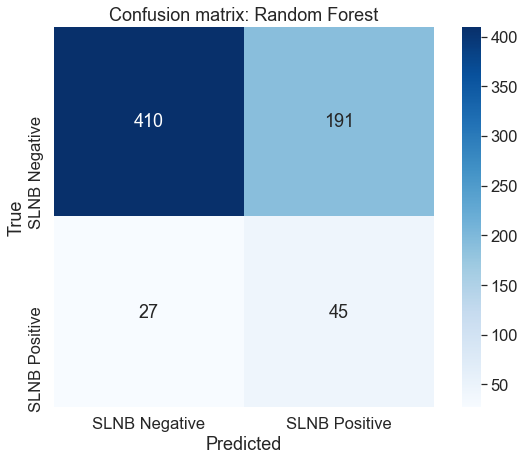

In [47]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [51]:
with open(BASE_DIR+'../model/balanced_rf.pkl', 'wb') as f:
    pkl.dump(rf, f)

## Binning the columns

In [29]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_augmented_clean.pkl')
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE',
                        'TUMOR_SIZE', 'DEPTH', 
                        'LYMPH_VASCULAR_INVASION', 
                        'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 
                        'GROWTH_PATTERN',
                        'TUMOR_BASE_TRANSECTION',
                        'SLNB'
                       ]]


In [30]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,1,C444,10,999.0,0,999,999,999,999,0.0
12,87,1,C447,999,999.0,9,999,999,999,999,1.0
14,43,1,C443,2,10.0,9,0,0,999,20,0.0
19,59,2,C447,25,50.0,0,999,999,999,999,0.0
21,75,2,C446,30,999.0,9,999,999,999,999,1.0


In [31]:
mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].value_counts()

999.0    7217
10.0     1159
20.0      988
0.0       526
Name: TUMOR_BASE_TRANSECTION, dtype: int64

In [32]:
# binning the categories
mcc_ncdb_sel['SEX'] = mcc_ncdb_sel['SEX'].replace([1, 2],
                                                ['Male', 'Female']
                                               )
mcc_ncdb_sel['PRIMARY_SITE'] = mcc_ncdb_sel['PRIMARY_SITE'].replace(['C440','C441','C442','C443',
                                                                     'C444','C445','C446','C447',
                                                                     'C448','C449'],
                                                                    ['Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Other',
                                                                     'Head_and_Neck',
                                                                     'Trunk',
                                                                     'Extremity',
                                                                     'Extremity',
                                                                     'Other',
                                                                     'Other']
                                                                   )
mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'] = mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'].replace([0, 1, 8, 9],
                                                                                          ['No',
                                                                                           'Yes',
                                                                                           'Unknown',
                                                                                           'Unknown'
                                                                                          ])
mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'].replace(
                                                                                          [0, 1, 20, 30, 999],
                                                                                          ['Negative',
                                                                                           'Weak',
                                                                                           'Strong',
                                                                                           'Present',
                                                                                           'Unknown'
                                                                                          ])
mcc_ncdb_sel['IMMUNE_SUPPRESSION'] = mcc_ncdb_sel['IMMUNE_SUPPRESSION'].replace(
                                                                              [0, 1, 20, 30, 40,
                                                                               50, 60, 70, 999],
                                                                              ['Negative',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Unknown'
                                                                              ])
mcc_ncdb_sel['GROWTH_PATTERN'] = mcc_ncdb_sel['GROWTH_PATTERN'].replace([1, 20, 999],
                                                                          ['Circumscribed_nodular',
                                                                           'Diffusely_infiltrative',
                                                                           'Unknown'])

mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'] = mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].replace([0, 1, 20, 999],
                                                                                          ['Not_found',
                                                                                           'Transected',
                                                                                           'Not_transected',
                                                                                           'Unknown'
                                                                                          ])

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a cop

## Imputing DEPTH and TUMOR_SIZE to be zero

In [33]:
mcc_ncdb_sel['DEPTH'] = mcc_ncdb_sel['DEPTH'].replace([999],[0])
mcc_ncdb_sel['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE'].replace([999],[0])

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,Male,Head_and_Neck,10,0.0,No,Unknown,Unknown,Unknown,Unknown,0.0
12,87,Male,Extremity,0,0.0,Unknown,Unknown,Unknown,Unknown,Unknown,1.0
14,43,Male,Other,2,10.0,Unknown,Negative,Negative,Unknown,Not_transected,0.0
19,59,Female,Extremity,25,50.0,No,Unknown,Unknown,Unknown,Unknown,0.0
21,75,Female,Extremity,30,0.0,Unknown,Unknown,Unknown,Unknown,Unknown,1.0


In [35]:
mcc_ncdb_sel.TUMOR_SIZE.value_counts()

0      2041
10      574
15      468
20      424
992     407
       ... 
270       1
180       1
148       1
108       1
220       1
Name: TUMOR_SIZE, Length: 132, dtype: int64

In [36]:
# save cleaned data
mcc_ncdb_sel.to_csv(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars.csv")
mcc_ncdb_sel.to_pickle(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars.pkl")

In [37]:
mcc_ncdb_sel = pd.get_dummies(mcc_ncdb_sel)
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [38]:
X_train_sel.shape

(8901, 28)

In [39]:
mcc_ncdb_sel.columns

Index(['AGE', 'TUMOR_SIZE', 'DEPTH', 'SLNB', 'SEX_Female', 'SEX_Male',
       'PRIMARY_SITE_Extremity', 'PRIMARY_SITE_Head_and_Neck',
       'PRIMARY_SITE_Other', 'PRIMARY_SITE_Trunk',
       'LYMPH_VASCULAR_INVASION_No', 'LYMPH_VASCULAR_INVASION_Unknown',
       'LYMPH_VASCULAR_INVASION_Yes', 'TUMOR_INFILTRATING_LYMPHOCYTES_10.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Negative',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Present',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Strong',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Unknown', 'IMMUNE_SUPPRESSION_10.0',
       'IMMUNE_SUPPRESSION_Negative', 'IMMUNE_SUPPRESSION_Positive',
       'IMMUNE_SUPPRESSION_Unknown', 'GROWTH_PATTERN_10.0',
       'GROWTH_PATTERN_Diffusely_infiltrative', 'GROWTH_PATTERN_Unknown',
       'TUMOR_BASE_TRANSECTION_10.0', 'TUMOR_BASE_TRANSECTION_Not_found',
       'TUMOR_BASE_TRANSECTION_Not_transected',
       'TUMOR_BASE_TRANSECTION_Unknown'],
      dtype='object')

In [40]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1000,
                            max_depth=50,
                            max_features = 7,
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6228513650151668
test NPV: 0.8127272727272727
test Precision: 0.38496583143507973
test Recall: 0.6213235294117647
test AUC: 0.6747220854869144
test F1: 0.4753867791842476
test AUPR: 0.42123272915015514


In [28]:
# RandomForest + Bayesian optimization
opt_rf = BayesSearchCV(BalancedRandomForestClassifier(oob_score=True,
                                     random_state=123),
                       {
                        'n_estimators': (100,2000),
                        'max_depth': (5, 100),  
                        'criterion': ['gini','entropy'],
                        'max_features': (1, 27),
                       }, 
                        n_iter = 20, verbose = 5, 
                       scoring=make_scorer(f1_score),
                       n_jobs=6)

# callback handler
def on_step(optim_result):
    score = opt_rf.best_score_
    print("best score: %s" % score)
#     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
#         pkl.dump(opt_rf, pickle_file)
    if score >= 0.99:
        print('Interrupting...')
        return True
    
opt_rf.fit(X_train_sel, y_train_sel.ravel(), callback=[on_step])

print("best parameter set: %s" % opt_rf.best_params_)
print("val. score: %s" % opt_rf.best_score_)
# print("test score: %s" % opt_rf.score(X_test, y_test))
y_prob_sel = np.asarray(opt_rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(opt_rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.4s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29357736638841975
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   10.5s remaining:   15.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   10.6s finished


best score: 0.29357736638841975
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.8s finished


best score: 0.29357736638841975
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   17.5s remaining:   26.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   17.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29357736638841975
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29749733422600366
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   11.9s remaining:   17.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   12.1s finished


best score: 0.29749733422600366
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   23.2s remaining:   34.8s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   23.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29749733422600366
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   18.0s remaining:   26.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   18.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.29749733422600366
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   23.4s remaining:   35.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   23.4s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   20.5s remaining:   30.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   20.6s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   20.8s remaining:   31.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   20.9s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.2s remaining:    9.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.3s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.3s remaining:    9.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.3s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.1s finished


best score: 0.2992359104983263
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.7s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    9.3s finished


best score: 0.3047739028383401
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   16.7s remaining:   25.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   16.8s finished


best score: 0.3064860722534881
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.9s finished


best score: 0.3064860722534881
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   17.3s remaining:   26.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   17.5s finished


best score: 0.3064860722534881
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.3s finished


best score: 0.3064860722534881
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   21.4s remaining:   32.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   21.5s finished


best score: 0.3064860722534881
best parameter set: OrderedDict([('criterion', 'gini'), ('max_depth', 5), ('max_features', 24), ('n_estimators', 2250)])
val. score: 0.3064860722534881
test accuracy: 0.6264274061990212
test NPV: 0.8844086021505376
test Precision: 0.22821576763485477
test Recall: 0.5612244897959183
test AUC: 0.6533584307509412
test F1: 0.3244837758112094
test AUPR: 0.3379450087365217


In [21]:
# def adjusted_classes(y_scores, t):
#     """
#     This function adjusts class predictions based on the prediction threshold (t).
#     Will only work for binary classification problems.
#     Credit to: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65#:~:text=The%20default%20threshold%20for%20RandomForestClassifier,the%20class%20probabilites%20called%20y_scores%20.
#     """
#     return np.asarray([1 if y >= t else 0 for y in y_scores])

# def precision_recall_threshold(p, r, thresholds, t=0.5):
#     """
#     plots the precision recall curve and shows the current value for each
#     by identifying the classifier's threshold (t).
#     """
    
#     # generate new class predictions based on the adjusted_classes
#     # function above and view the resulting confusion matrix.
#     y_pred_adj = adjusted_classes(y_scores, t)
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
#                        columns=['pred_neg', 'pred_pos'], 
#                        index=['neg', 'pos']))
    
#     # plot the curve
#     plt.figure(figsize=(8,8))
#     plt.title("Precision and Recall curve ^ = current threshold")
#     plt.step(r, p, color='b', alpha=0.2,
#              where='post')
#     plt.fill_between(r, p, step='post', alpha=0.2,
#                      color='b')
#     plt.ylim([0.5, 1.01]);
#     plt.xlim([0.5, 1.01]);
#     plt.xlabel('Recall');
#     plt.ylabel('Precision');
    
#     # plot the current threshold on the line
#     close_default_clf = np.argmin(np.abs(thresholds - t))
#     plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
#             markersize=15)

In [22]:
# decision threshold
# t = len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 0])/(len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 0]) + \
#                                                   len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 1]))
# t = 0.56

In [23]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1033,#1444
                            max_depth=6,#9
                            max_features = 1,#10
                            criterion = 'gini',
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())

y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6639477977161501
test NPV: 0.8872180451127819
test Precision: 0.24766355140186916
test Recall: 0.5408163265306123
test AUC: 0.664612641172974
test F1: 0.3397435897435898
test AUPR: 0.3353676606393452


In [24]:
# y_scores = y_prob_sel[:,1]
# p, r, thresholds = precision_recall_curve(y_test_sel, y_scores)
# precision_recall_threshold(p, r, thresholds, 0.56)

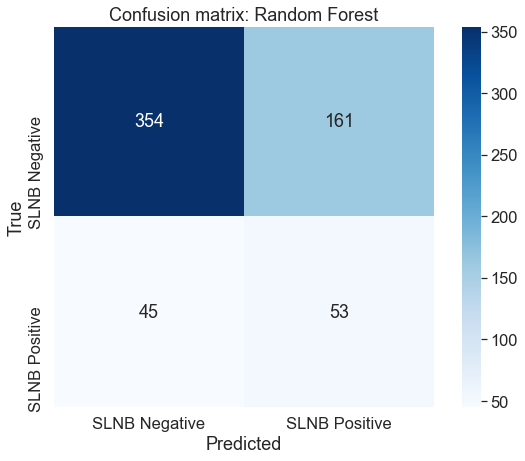

In [25]:
cm = confusion_matrix(y_test_sel, y_pred_sel)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [29]:
# pickling model
with open(BASE_DIR+'../model/balanced_rf_imputed_binned.pkl', 'wb') as f:
    pkl.dump(rf, f)

## Try different imputation

In [41]:
# read in data
mcc_ncdb = pd.read_pickle(BASE_DIR + '../data/Merkel_NCDB_augmented_clean.pkl')
# subset of features only
mcc_ncdb_sel = mcc_ncdb[['AGE','SEX','PRIMARY_SITE',
                        'TUMOR_SIZE', 'DEPTH', 
                        'LYMPH_VASCULAR_INVASION', 
                        'TUMOR_INFILTRATING_LYMPHOCYTES',
                        'IMMUNE_SUPPRESSION', 
                        'GROWTH_PATTERN',
                        'TUMOR_BASE_TRANSECTION',
                        'SLNB'
                       ]]


In [42]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,1,C444,10,999.0,0,999,999,999,999,0.0
12,87,1,C447,999,999.0,9,999,999,999,999,1.0
14,43,1,C443,2,10.0,9,0,0,999,20,0.0
19,59,2,C447,25,50.0,0,999,999,999,999,0.0
21,75,2,C446,30,999.0,9,999,999,999,999,1.0


In [43]:
mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].value_counts()

999.0    7217
10.0     1159
20.0      988
0.0       526
Name: TUMOR_BASE_TRANSECTION, dtype: int64

In [44]:
# binning the categories
mcc_ncdb_sel['SEX'] = mcc_ncdb_sel['SEX'].replace([1, 2],
                                                ['Male', 'Female']
                                               )
mcc_ncdb_sel['PRIMARY_SITE'] = mcc_ncdb_sel['PRIMARY_SITE'].replace(['C440','C441','C442','C443',
                                                                     'C444','C445','C446','C447',
                                                                     'C448','C449'],
                                                                    ['Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Head_and_Neck',
                                                                     'Other',
                                                                     'Head_and_Neck',
                                                                     'Trunk',
                                                                     'Extremity',
                                                                     'Extremity',
                                                                     'Other',
                                                                     'Other']
                                                                   )
mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'] = mcc_ncdb_sel['LYMPH_VASCULAR_INVASION'].replace([0, 1, 8, 9],
                                                                                          ['No',
                                                                                           'Yes',
                                                                                           'Unknown',
                                                                                           'Unknown'
                                                                                          ])
mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'] = mcc_ncdb_sel['TUMOR_INFILTRATING_LYMPHOCYTES'].replace(
                                                                                          [0, 1, 20, 30, 999],
                                                                                          ['Negative',
                                                                                           'Weak',
                                                                                           'Strong',
                                                                                           'Present',
                                                                                           'Unknown'
                                                                                          ])
mcc_ncdb_sel['IMMUNE_SUPPRESSION'] = mcc_ncdb_sel['IMMUNE_SUPPRESSION'].replace(
                                                                              [0, 1, 20, 30, 40,
                                                                               50, 60, 70, 999],
                                                                              ['Negative',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Positive',
                                                                               'Unknown'
                                                                              ])
mcc_ncdb_sel['GROWTH_PATTERN'] = mcc_ncdb_sel['GROWTH_PATTERN'].replace([1, 20, 999],
                                                                          ['Circumscribed_nodular',
                                                                           'Diffusely_infiltrative',
                                                                           'Unknown'])

mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'] = mcc_ncdb_sel['TUMOR_BASE_TRANSECTION'].replace([0, 1, 20, 999],
                                                                                          ['Not_found',
                                                                                           'Transected',
                                                                                           'Not_transected',
                                                                                           'Unknown'
                                                                                          ])

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [45]:
# store a copy
mcc_ncdb_sel_cp = deepcopy(mcc_ncdb_sel)

## Imputing DEPTH and TUMOR_SIZE using kNN

In [46]:
mcc_ncdb_sel['DEPTH'] = mcc_ncdb_sel['DEPTH'].replace([999],np.NaN)
mcc_ncdb_sel['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE'].replace([999],np.NaN)

/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yanrongji/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
mcc_ncdb_sel.head()

,AGE,SEX,PRIMARY_SITE,TUMOR_SIZE,DEPTH,LYMPH_VASCULAR_INVASION,TUMOR_INFILTRATING_LYMPHOCYTES,IMMUNE_SUPPRESSION,GROWTH_PATTERN,TUMOR_BASE_TRANSECTION,SLNB
8,71,Male,Head_and_Neck,10.0,NaN,No,Unknown,Unknown,Unknown,Unknown,0.0
12,87,Male,Extremity,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,1.0
14,43,Male,Other,2.0,10.0,Unknown,Negative,Negative,Unknown,Not_transected,0.0
19,59,Female,Extremity,25.0,50.0,No,Unknown,Unknown,Unknown,Unknown,0.0
21,75,Female,Extremity,30.0,NaN,Unknown,Unknown,Unknown,Unknown,Unknown,1.0


In [48]:
mcc_ncdb_sel = pd.get_dummies(mcc_ncdb_sel)
X_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns != 'SLNB'])
y_sel = np.array(mcc_ncdb_sel.loc[:, mcc_ncdb_sel.columns == 'SLNB'])
# impute by KNN
imputer = KNNImputer()
X_sel = imputer.fit_transform(X_sel).round()
# split data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, 
                                                                test_size = 0.1, 
                                                                random_state = 123) # set seed to ensure reproducibility

In [49]:
mcc_ncdb_sel.columns

Index(['AGE', 'TUMOR_SIZE', 'DEPTH', 'SLNB', 'SEX_Female', 'SEX_Male',
       'PRIMARY_SITE_Extremity', 'PRIMARY_SITE_Head_and_Neck',
       'PRIMARY_SITE_Other', 'PRIMARY_SITE_Trunk',
       'LYMPH_VASCULAR_INVASION_No', 'LYMPH_VASCULAR_INVASION_Unknown',
       'LYMPH_VASCULAR_INVASION_Yes', 'TUMOR_INFILTRATING_LYMPHOCYTES_10.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Negative',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Present',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Strong',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Unknown', 'IMMUNE_SUPPRESSION_10.0',
       'IMMUNE_SUPPRESSION_Negative', 'IMMUNE_SUPPRESSION_Positive',
       'IMMUNE_SUPPRESSION_Unknown', 'GROWTH_PATTERN_10.0',
       'GROWTH_PATTERN_Diffusely_infiltrative', 'GROWTH_PATTERN_Unknown',
       'TUMOR_BASE_TRANSECTION_10.0', 'TUMOR_BASE_TRANSECTION_Not_found',
       'TUMOR_BASE_TRANSECTION_Not_transected',
       'TUMOR_BASE_TRANSECTION_Unknown'],
      dtype='object')

In [50]:
# save imputer
with open(BASE_DIR+'../model/knn_imputer_augmented.pkl', 'wb') as f:
    pkl.dump(imputer, f)

In [51]:
mcc_ncdb_sel = pd.DataFrame(np.concatenate([X_sel[:,:3],y_sel,X_sel[:,3:]], axis=1), columns=mcc_ncdb_sel.columns)
mcc_ncdb_sel_notencoded = mcc_ncdb_sel_cp
mcc_ncdb_sel_notencoded['DEPTH'] = mcc_ncdb_sel['DEPTH']
mcc_ncdb_sel_notencoded['TUMOR_SIZE'] = mcc_ncdb_sel['TUMOR_SIZE']

In [52]:
# save cleaned data
mcc_ncdb_sel.to_csv(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_encoded_imputed.csv")
mcc_ncdb_sel.to_pickle(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_encoded_imputed.pkl")
mcc_ncdb_sel_notencoded.to_csv(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_imputed.csv")
mcc_ncdb_sel_notencoded.to_pickle(BASE_DIR+"../data/Merkel_NCDB_augmented_clean_selectedVars_imputed.pkl")

In [53]:
X_train_sel.shape

(8901, 28)

In [54]:
mcc_ncdb_sel.columns

Index(['AGE', 'TUMOR_SIZE', 'DEPTH', 'SLNB', 'SEX_Female', 'SEX_Male',
       'PRIMARY_SITE_Extremity', 'PRIMARY_SITE_Head_and_Neck',
       'PRIMARY_SITE_Other', 'PRIMARY_SITE_Trunk',
       'LYMPH_VASCULAR_INVASION_No', 'LYMPH_VASCULAR_INVASION_Unknown',
       'LYMPH_VASCULAR_INVASION_Yes', 'TUMOR_INFILTRATING_LYMPHOCYTES_10.0',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Negative',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Present',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Strong',
       'TUMOR_INFILTRATING_LYMPHOCYTES_Unknown', 'IMMUNE_SUPPRESSION_10.0',
       'IMMUNE_SUPPRESSION_Negative', 'IMMUNE_SUPPRESSION_Positive',
       'IMMUNE_SUPPRESSION_Unknown', 'GROWTH_PATTERN_10.0',
       'GROWTH_PATTERN_Diffusely_infiltrative', 'GROWTH_PATTERN_Unknown',
       'TUMOR_BASE_TRANSECTION_10.0', 'TUMOR_BASE_TRANSECTION_Not_found',
       'TUMOR_BASE_TRANSECTION_Not_transected',
       'TUMOR_BASE_TRANSECTION_Unknown'],
      dtype='object')

In [55]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1000,
                            max_depth=50,
                            max_features = 7,
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())
y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

test accuracy: 0.6329625884732053
test NPV: 0.8062283737024222
test Precision: 0.38929440389294406
test Recall: 0.5882352941176471
test AUC: 0.6765885224382641
test F1: 0.4685212298682284
test AUPR: 0.43203071532291437


In [56]:
# RandomForest + Bayesian optimization
opt_rf = BayesSearchCV(BalancedRandomForestClassifier(oob_score=True,
                                     random_state=123),
                       {
                        'n_estimators': (100,2000),
                        'max_depth': (5, 100),  
                        'criterion': ['gini','entropy'],
                        'max_features': (1, 27),
                       }, 
                        n_iter = 20, verbose = 5, 
                       scoring=make_scorer(f1_score),
                       n_jobs=6)

# callback handler
def on_step(optim_result):
    score = opt_rf.best_score_
    print("best score: %s" % score)
#     with open("./rf_checkpoint.pkl", 'wb') as pickle_file:
#         pkl.dump(opt_rf, pickle_file)
    if score >= 0.5:
        print('Interrupting...')
        return True
    
opt_rf.fit(X_train_sel, y_train_sel.ravel(), callback=[on_step])

print("best parameter set: %s" % opt_rf.best_params_)
print("val. score: %s" % opt_rf.best_score_)
# print("test score: %s" % opt_rf.score(X_test, y_test))
y_prob_sel = np.asarray(opt_rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(opt_rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   41.7s remaining:  1.0min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   42.2s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.4757765769348422
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   32.8s remaining:   49.2s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   34.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.9s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   22.3s remaining:   33.5s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   22.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   34.1s remaining:   51.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   34.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   50.2s remaining:  1.3min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   50.4s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    5.4s remaining:    8.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    5.5s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   34.6s remaining:   51.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   34.8s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   28.9s remaining:   43.4s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   29.1s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   19.6s remaining:   29.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   19.7s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   13.5s remaining:   20.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   13.7s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    1.3s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   30.6s remaining:   45.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   30.8s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   57.2s remaining:  1.4min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   57.4s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   35.3s remaining:   52.9s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   35.5s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   57.8s remaining:  1.4min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   58.0s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:  1.1min finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.0s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   44.0s remaining:  1.1min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   45.5s finished


best score: 0.49073822526665467
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   28.2s remaining:   42.3s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   28.5s finished


best score: 0.4927433400189125
best parameter set: OrderedDict([('criterion', 'entropy'), ('max_depth', 8), ('max_features', 9), ('n_estimators', 1493)])
val. score: 0.4927433400189125
test accuracy: 0.6208291203235592
test NPV: 0.8379446640316206
test Precision: 0.39337474120082816
test Recall: 0.6985294117647058
test AUC: 0.6984166051357782
test F1: 0.5033112582781457
test AUPR: 0.46643940164150344


In [21]:
# def adjusted_classes(y_scores, t):
#     """
#     This function adjusts class predictions based on the prediction threshold (t).
#     Will only work for binary classification problems.
#     Credit to: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65#:~:text=The%20default%20threshold%20for%20RandomForestClassifier,the%20class%20probabilites%20called%20y_scores%20.
#     """
#     return np.asarray([1 if y >= t else 0 for y in y_scores])

# def precision_recall_threshold(p, r, thresholds, t=0.5):
#     """
#     plots the precision recall curve and shows the current value for each
#     by identifying the classifier's threshold (t).
#     """
    
#     # generate new class predictions based on the adjusted_classes
#     # function above and view the resulting confusion matrix.
#     y_pred_adj = adjusted_classes(y_scores, t)
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
#                        columns=['pred_neg', 'pred_pos'], 
#                        index=['neg', 'pos']))
    
#     # plot the curve
#     plt.figure(figsize=(8,8))
#     plt.title("Precision and Recall curve ^ = current threshold")
#     plt.step(r, p, color='b', alpha=0.2,
#              where='post')
#     plt.fill_between(r, p, step='post', alpha=0.2,
#                      color='b')
#     plt.ylim([0.5, 1.01]);
#     plt.xlim([0.5, 1.01]);
#     plt.xlabel('Recall');
#     plt.ylabel('Precision');
    
#     # plot the current threshold on the line
#     close_default_clf = np.argmin(np.abs(thresholds - t))
#     plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
#             markersize=15)

In [22]:
# decision threshold
# t = len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 0])/(len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 0]) + \
#                                                   len(mcc_ncdb_sel[mcc_ncdb_sel['SLNB'] == 1]))
# t = 0.56

In [57]:
# train a random forest classifier
rf = BalancedRandomForestClassifier(
                            n_estimators=1493,#1444, 1961
                            max_depth=8,#9, 6
                            max_features = 9,#10, 4
                            criterion = 'entropy',
                            oob_score=True, 
                            random_state=123) # set seed to ensure reproducibility
rf.fit(X_train_sel,y_train_sel.ravel())

y_prob_sel = np.asarray(rf.predict_proba(X_test_sel))
y_pred_sel = np.asarray(rf.predict(X_test_sel))
y_test_sel = np.asarray(y_test_sel)
print("test accuracy: %s" % accuracy_score(y_test_sel, y_pred_sel))
print("test NPV: %s" % negative_pred_value(y_test_sel, y_pred_sel))
print("test Precision: %s" % precision_score(y_test_sel, y_pred_sel))
print("test Recall: %s" % recall_score(y_test_sel, y_pred_sel))
print("test AUC: %s" % roc_auc_score(y_test_sel, y_prob_sel[:,1]))
print("test F1: %s" % f1_score(y_test_sel, y_pred_sel))
print("test AUPR: %s" % average_precision_score(y_test_sel, y_prob_sel[:,1]))

# 0.649, 0.8906, 0.245, 0.571, 0.668, 0.343, 0.346

test accuracy: 0.6208291203235592
test NPV: 0.8379446640316206
test Precision: 0.39337474120082816
test Recall: 0.6985294117647058
test AUC: 0.6984166051357782
test F1: 0.5033112582781457
test AUPR: 0.46643940164150344


In [92]:
# y_scores = y_prob_sel[:,1]
# p, r, thresholds = precision_recall_curve(y_test_sel, y_scores)
# precision_recall_threshold(p, r, thresholds, 0.56)

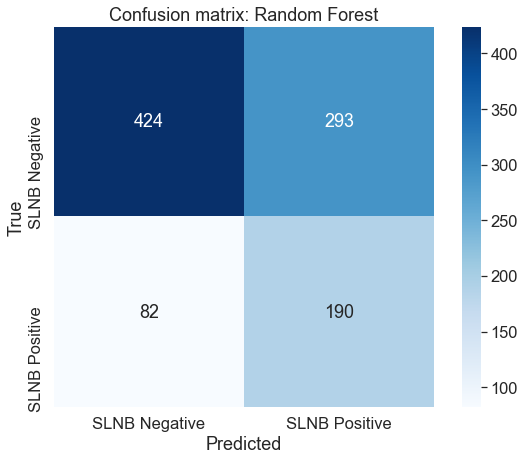

In [58]:
cm = confusion_matrix(y_test_sel, y_pred_sel)
df_cm = pd.DataFrame(cm, index = [i for i in ["SLNB Negative","SLNB Positive"]],
                  columns = [i for i in ["SLNB Negative","SLNB Positive"]])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, cmap='Blues',square=True, fmt='d').set_title('Confusion matrix: Random Forest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(BASE_DIR+'../image/confusion_matrix.pdf')

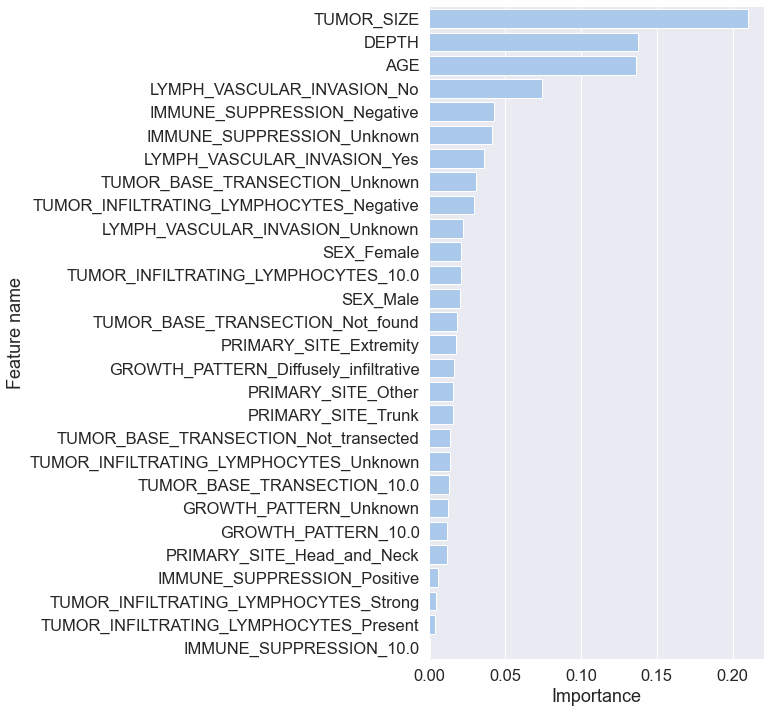

In [59]:
# feature importance
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

#mcc_ncdb_sel.drop(['SLNB'], axis=1).columns
# feature importances
imp = rf.feature_importances_
imp_df = pd.DataFrame(data={"Feature name": mcc_ncdb_sel.drop(['SLNB'], axis=1).columns,
                      "Importance": imp}
                     ).sort_values("Importance", ascending=False)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 12))
sns.set_color_codes("pastel")
sns.barplot(x="Importance", y="Feature name", data=imp_df, color="b")
sns.despine(left=True, bottom=True)
plt.savefig(BASE_DIR+'../image/feature_importance.png', bbox_inches='tight')

In [60]:
# pickling model
with open(BASE_DIR+'../model/balanced_rf_augmented_knnimputed_binned.pkl', 'wb') as f:
    pkl.dump(rf, f)